In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import re
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('train.csv')

# Drop unnecessary columns including 'Lname' if present
X = data.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)

# Fill missing values
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
X['Age'] = X['Age'].fillna(X['Age'].mean())  # Ensure Age is filled before binning

# Standardize the 'Fare' column
scaler = StandardScaler()
X['Fare'] = scaler.fit_transform(X[['Fare']])

# Extract titles from 'Name' using a corrected regex pattern with a raw string
def extract_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

X['Title'] = X['Name'].apply(extract_title)

# Simplify titles to common ones
title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'}
X['Title'] = X['Title'].apply(lambda x: title_mapping[x] if x in title_mapping else 'Other')

# Define age bins and assign
bins = [0, 9, 14, 42, 57, 59, 100]
labels = range(len(bins) - 1)
X['AgeBin'] = pd.cut(X['Age'], bins=bins, labels=labels)

# Now drop the original 'Age' column
X = X.drop(['Age'], axis=1)

# Calculate FamilySize
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

# One hot encode 'Embarked', 'Title', and 'Sex'
X = pd.get_dummies(X, columns=['Embarked', 'Title', 'Sex'], drop_first=True)

# Drop 'Name', 'SibSp', and 'Parch' columns
X = X.drop(['Name', 'SibSp', 'Parch'], axis=1)

# Extract 'Survived' column and convert to boolean
y = data['Survived'].astype(bool)

# Combine the features with the target column
# X['Survived'] = y

# Save the fully preprocessed DataFrame to a CSV file
# X.to_csv('titanic_preprocessed.csv', index=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X

,Pclass,Fare,AgeBin,FamilySize,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male
0,3,-0.502445,2,2,False,True,False,True,False,False,True
1,1,0.786845,2,2,False,False,False,False,True,False,False
2,3,-0.488854,2,1,False,True,True,False,False,False,False
3,1,0.420730,2,2,False,True,False,False,True,False,False
4,3,-0.486337,2,1,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
886,2,-0.386671,2,1,False,True,False,False,False,True,True
887,1,-0.044381,2,1,False,True,True,False,False,False,False
888,3,-0.176263,2,4,False,True,True,False,False,False,False
889,1,-0.044381,2,1,False,False,False,True,False,False,True


In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_splivery-cool-workspacet': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, 
                           cv=3, 
                           verbose=3,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.805 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.714 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.805 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.738 total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.805 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.805 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.762 total time=   1.6s

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=3)

In [42]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

params = {
    'bootstrap': True,
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 100
}

rf_classifier = RandomForestClassifier(**params)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Random Forest model: {accuracy:.2f}")

Accuracy of the Random Forest model: 0.69


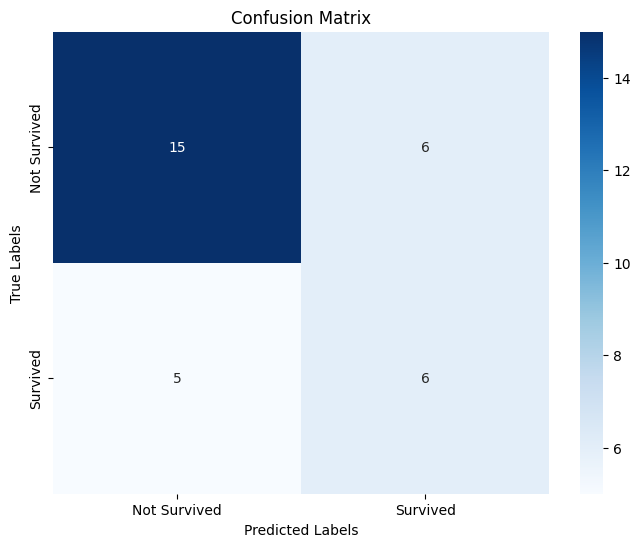

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already made predictions using your model
y_pred = rf_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

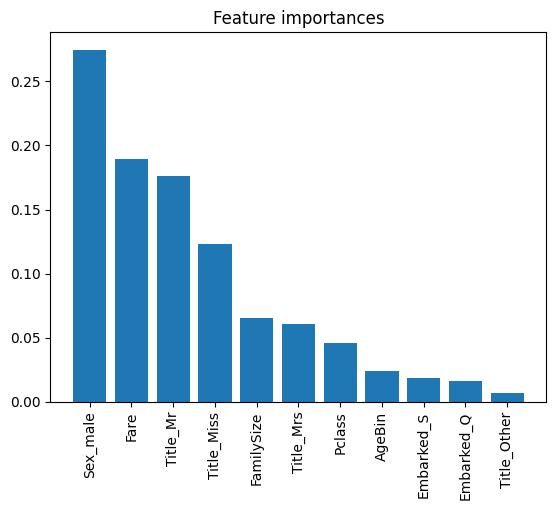

In [54]:
import matplotlib.pyplot as plt

# Train model
rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Plot feature importances
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()
